<a href="https://colab.research.google.com/github/Sahil-Chhabra-09/Convolution-Neural-Networks/blob/main/Building_resnet50_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model

## Problem with very deep neural networks

Vanishing and Exploding gradient

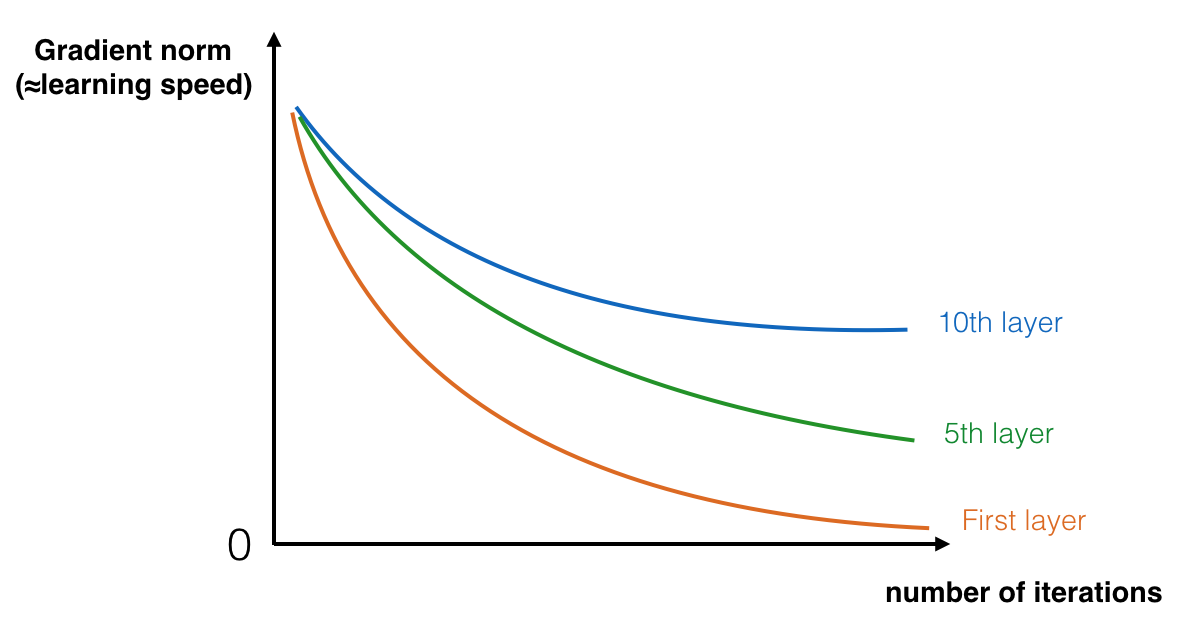

## Building a Residual Network

### The Identity Block

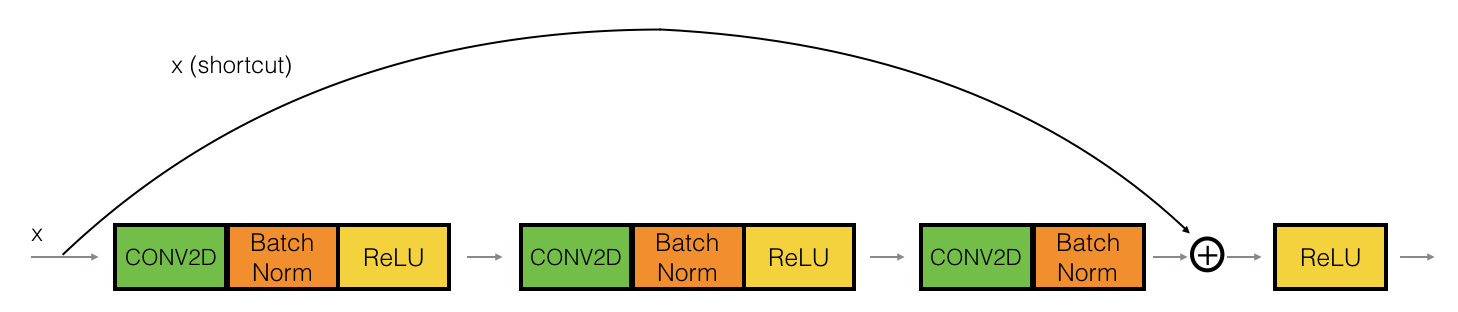

In [2]:
def identity_block(X, f, filters, training=True):
    """
    Implementation of the identity block as defined in above figure
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    
    ## Final step: Adding shortcut value to main path, and passing it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

### The convolutional block

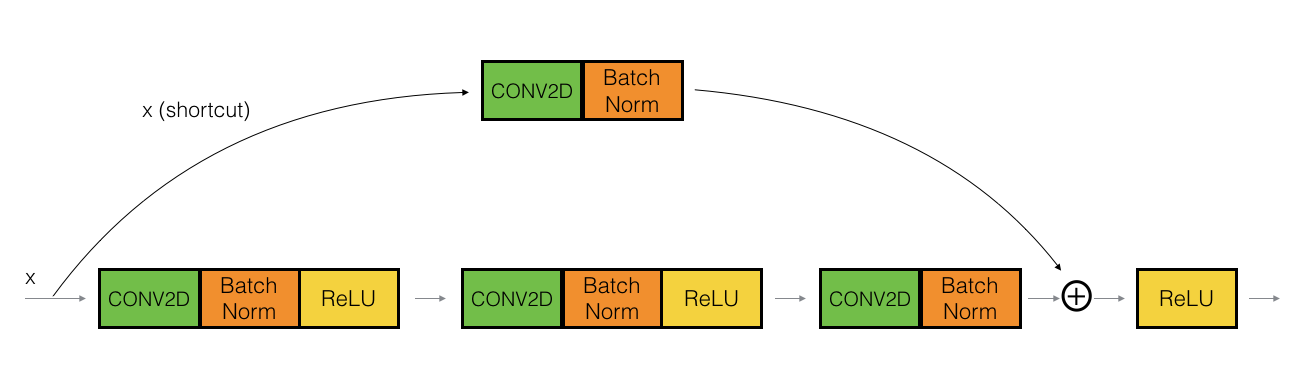

In [3]:
def convolutional_block(X, f, filters, s = 2, training=True):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid')(X) 
    X = BatchNormalization(axis = 3)(X, training = training)
    
    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s,s), padding = 'valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)
    

    # Final step: Adding shortcut value to main path, and passing it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

### ResNet Model (50 layers)

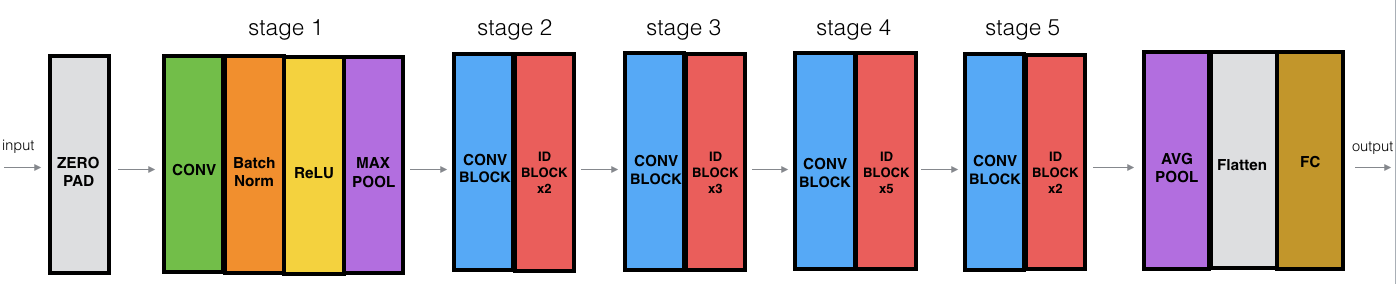

In [4]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    
    ## Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    
    X = identity_block(X, f = 3, filters = [128, 128, 512])
    X = identity_block(X, f = 3, filters = [128, 128, 512])
    X = identity_block(X, f = 3, filters = [128, 128, 512])

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    
    X = identity_block(X, f = 3, filters = [512, 512, 2048])
    X = identity_block(X, f = 3, filters = [512, 512, 2048])

    X = AveragePooling2D(pool_size = (2,2))(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [18]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_53 (Conv2D)             (None, 32, 32, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                                  
 batch_normalization_53 (BatchN  (None, 32, 32, 64)  256         ['conv2d_53[0][0]']        

In [19]:
model.compile(
    optimizer = 'adam', 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

### Loading sign dataset

In [7]:
import numpy as np
import h5py

def load_signs_dataset():
    train_dataset = h5py.File('/content/drive/MyDrive/Hand Sign/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('/content/drive/MyDrive/Hand Sign/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [8]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

In [9]:
def convert_to_one_hot(X, classes):
  return np.eye(classes)[X.reshape(-1)]

Sign : 2


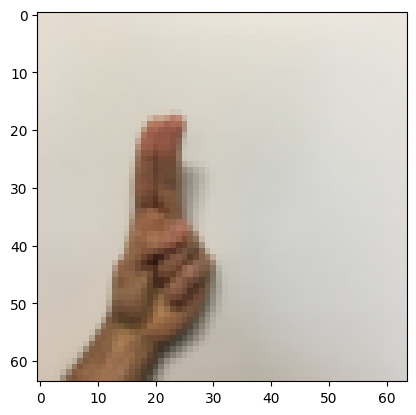

In [10]:
import matplotlib.pyplot as plt
print("Sign : " + str(Y_train_orig[0][10]))
plt.imshow(X_train_orig[10])

In [11]:
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

In [12]:
Y_train[:10]

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [13]:
X_train = X_train_orig/255
X_test = X_test_orig/255

In [14]:
X_train.shape

(1080, 64, 64, 3)

In [15]:
Y_train.shape

(1080, 6)

In [20]:
history = model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
34/34 [==============================] - 223s 6s/step - loss: 2.3128 - accuracy: 0.4241
Epoch 2/10
34/34 [==============================] - 210s 6s/step - loss: 0.5787 - accuracy: 0.7917
Epoch 3/10
34/34 [==============================] - 192s 6s/step - loss: 0.3535 - accuracy: 0.8778
Epoch 4/10
34/34 [==============================] - 191s 6s/step - loss: 0.2772 - accuracy: 0.9083
Epoch 5/10
34/34 [==============================] - 189s 6s/step - loss: 0.2724 - accuracy: 0.9491
Epoch 6/10
34/34 [==============================] - 187s 6s/step - loss: 0.3504 - accuracy: 0.8778
Epoch 7/10
34/34 [==============================] - 187s 6s/step - loss: 0.1603 - accuracy: 0.9398
Epoch 8/10
34/34 [==============================] - 191s 6s/step - loss: 0.0373 - accuracy: 0.9880
Epoch 9/10
34/34 [==============================] - 188s 6s/step - loss: 0.1152 - accuracy: 0.9667
Epoch 10/10
34/34 [==============================] - 189s 6s/step - loss: 0.0935 - accuracy: 0.9759


In [21]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 3s 430ms/step - loss: 0.2533 - accuracy: 0.9250
Loss = 0.25328555703163147
Test Accuracy = 0.925000011920929


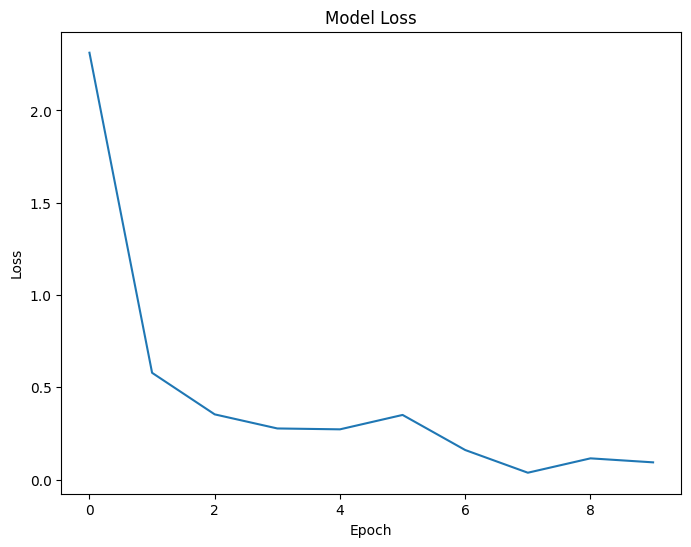

In [53]:
plt.figure(figsize = (8,6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.plot(history.history['loss'])

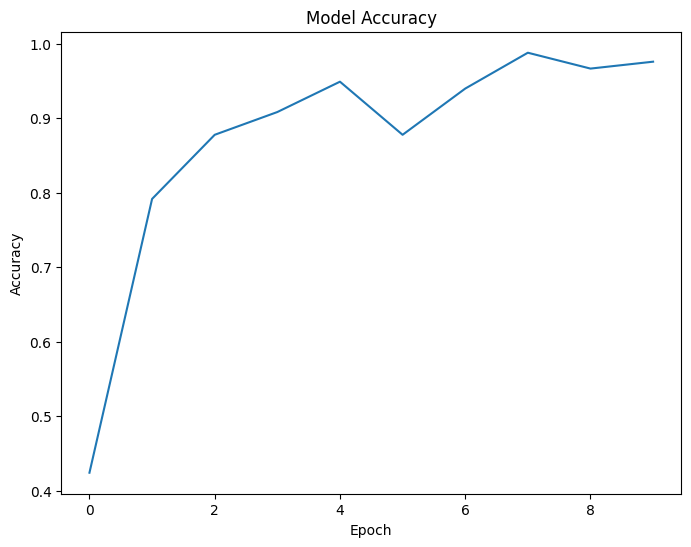

In [54]:
plt.figure(figsize = (8,6))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.plot(history.history['accuracy'])

#### Predicting sign of a random image from test dataset

In [58]:
X_test.shape

(120, 64, 64, 3)

In [65]:
test_img = X_test[int(round(np.random.rand()*120, 0))]

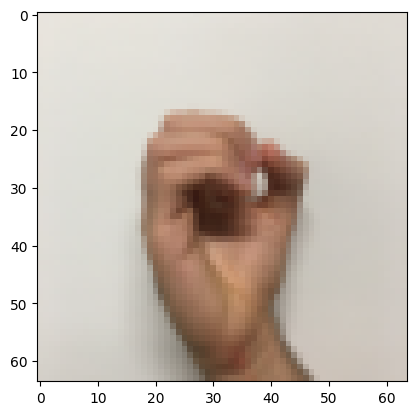

In [66]:
plt.imshow(test_img)

In [68]:
test_img.shape

(64, 64, 3)

In [71]:
test_img = test_img.reshape(1, 64, 64, 3)

In [72]:
test_img.shape

(1, 64, 64, 3)

In [75]:
prediction = np.argmax(model.predict(test_img))

1/1 [==============================] - 0s 155ms/step


In [76]:
print(f"Predicted Output : {prediction}")

Predicted Output : 0
